<span style="color:black;font-size:35px">**Ibrahim Fish Dataset**</span>

In [1]:
CWD = r'C:\Users\Evant\Desktop\cis472\latest\CIS472-CourseProject'
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms as T
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from tqdm import tqdm
import sys
sys.path.append(CWD+r'\models')
# sys.path.append(r'C:\Users\hansm\Github\CIS472-CourseProject\models')
from vgg import VGG16
from lenet import LeNet
from alexnet import AlexNet
sys.path.pop()
#sys.path.append(r'..\training')
# sys.path.append(r'C:\Users\hansm\Github\CIS472-CourseProject\training')
# from training import train_epoch
# sys.path.pop()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FILEPATH = r"..\..\FISH0006 fishclassifierfinal\intel-image-classification"
# FILEPATH = r"C:\Users\hansm\Github\CIS472-CourseProject\Project Datasets\Dataset3\FishClassifierFinal\archive\intel-image-classification"

In [2]:
def evaluate(model, test_data):
    model.eval()
    accuracy = 0
    with torch.no_grad():
        for (data, label) in test_data:
#             print(data)
            data = data.to(device)
#             label = torch.tensor(label)
#             print(label)
            label = label.to(device)
            out = model(data)
            answers = out.max(dim=1)[1]
#             answers = torch.max(out, dim=1)
#             print(answers)
            accuracy += (answers == label).sum()
    return accuracy

In [3]:
def train_epoch(model, train_data, LossFunction, optimizer):
#     model.to(device)
    model.train()
    loss_history = []
    acc_history = []
    correct = 0
    for (data, label) in tqdm(train_data, desc="iteration", unit="%", disable=True):
        # clear the gradients
        optimizer.zero_grad(set_to_none=True)
        
        # send the data and labels to the same device as the training model
        data = data.to(device)
#         print(label.shape)
        label = label.to(device)

        # get the output from the model
        out = model(data)
#         print(out.shape)
        _, output = torch.max(out, 1)
        
        # calculate loss
        loss = LossFunction(out, label)
        
        # calculate gradients and perform gradient descent
        loss.backward()
        optimizer.step()
        correct += (output == label).float().sum()
        loss_history.append(loss.item())
    accuracy = 100 * correct / len(fish_train_set)
    return loss_history, accuracy

In [4]:
# not really useful at the moment
class My_Dataset(Dataset):
    def __init__(self, data_path, transform=None):
        raise NotImplementedError
        
    def __len__(self):
        raise NotImplementedError
        
    def __getitem__(self, idx):
        raise NotImplementedError

In [5]:
class FishDataset(Dataset):
    def __init__(self, data_path, train=False, shuffle=False, transform=None):
        self.train = train
        self.transform = transform
        self.data_path = data_path
        datapoints = {}
        i = 0
        if train:
            for label in os.listdir(fr"{data_path}\seg_train\seg_train"):
                for image in os.listdir(fr"{data_path}\seg_train\seg_train\{label}"):
                    datapoints[image] = i
                i += 1
        else:
            for label in os.listdir(fr"{data_path}\seg_test\seg_test"):
                for image in os.listdir(fr"{data_path}\seg_test\seg_test\{label}"):
                    datapoints[image] = i
                i += 1
        self._num_labels = i
        if shuffle:
            k = list(datapoints.keys())
            random.shuffle(k)
            l = [(key, datapoints[key]) for key in k]
            datapoints = dict(l)
        self.labels = list(datapoints.values())
        self.images = list(datapoints.keys())
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        folders = os.listdir(fr"{self.data_path}\seg_train\seg_train")
        label = self.labels[idx]
        if self.train:
            img = Image.open(fr"{self.data_path}\seg_train\seg_train\{folders[label]}\{self.images[idx]}")
        else:
            img = Image.open(fr"{self.data_path}\seg_test\seg_test\{folders[label]}\{self.images[idx]}")
        # this data set contains a number of png files with an alpha channel
        img = img.convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
#         if not img.shape[0] == 3:
#             print(img.shape)
#             img = img.convert("RGB")
#             img.cv2.cvtColor(img, cv2.COLOR_BGRA)
        return img, label    

    def num_labels(self):
        return self._num_labels

In [6]:
fish_transform = T.Compose([T.Resize(size=(224,224)), 
                            T.RandomHorizontalFlip(), 
                            T.ToTensor(), 
                            T.Normalize(mean=[0.485, 0.456, 0.406], 
                                        std=[0.229, 0.224, 0.225])])

fish_train_set = FishDataset(FILEPATH, 
                             train=True, 
                             shuffle=True, 
                             transform=fish_transform)
fish_test_set = FishDataset(FILEPATH, 
                            train=False, 
                            shuffle=True, 
                            transform=fish_transform)

Type: <class 'list'>
Length: 2
More Types: <class 'torch.Tensor'>, <class 'torch.Tensor'>
Image Shapes: torch.Size([3, 224, 224]), torch.Size([3, 224, 224])
Labels: tensor([ 8, 29])



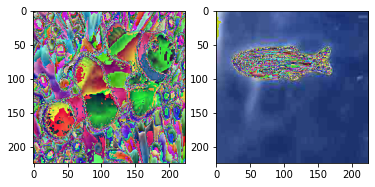

In [7]:
fish_investigation_dataset = DataLoader(fish_train_set, batch_size=2)
fish_data = iter(fish_investigation_dataset)
fish_single_point = next(fish_data)
print(f"""Type: {type(fish_single_point)}
Length: {len(fish_single_point)}
More Types: {type(fish_single_point[0])}, {type(fish_single_point[1])}
Image Shapes: {fish_single_point[0][0].shape}, {fish_single_point[0][1].shape}
Labels: {fish_single_point[1]}
""")

ToPIL = T.ToPILImage()
img0 = ToPIL(fish_single_point[0][0])
img1 = ToPIL(fish_single_point[0][1])
fi_1, axs_1 = plt.subplots(1,2)
axs_1[0].imshow(img0)
axs_1[1].imshow(img1)

<span style="color:black;font-size:35px">**VGG Training**</span>

In [8]:
vgg_learning_rate = 1e-1
vgg_nepochs = 8
fish_batch_size = 64

fish_train_dataset = DataLoader(fish_train_set, batch_size=fish_batch_size)
fish_test_dataset = DataLoader(fish_test_set, batch_size=fish_batch_size)

loss_function = nn.CrossEntropyLoss()

In [11]:
vgg = VGG16(hidden_features=512, nout=30, dropout=False).to(device)
# print(vgg)

vgg_optimizer_sgd = optim.SGD(vgg.parameters(), lr=vgg_learning_rate)

loss_function = nn.CrossEntropyLoss()

vgg.train()
vgg_loss_history = []
vgg_train_acc_history = []
vgg_test_acc_history = []
for epoch in tqdm(range(vgg_nepochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
#     vgg_loss_history.append
    loss_history, accuracy = (train_epoch(model=vgg, 
                                        train_data=fish_train_dataset, 
                                        LossFunction=loss_function, 
                                        optimizer=vgg_optimizer_sgd))
    vgg_loss_history.append(loss_history)
    vgg_train_acc_history.append(accuracy)
    vgg_test_acc_history.append((evaluate(vgg, fish_test_dataset) / len(fish_test_set)) * 100)

    print(f"Epoch {epoch}:\ntrain loss: {vgg_loss_history[-1][-1]}"
          f"\ntrain acc:  {float(vgg_train_acc_history[-1])} test acc: {float(vgg_test_acc_history[-1])}")

Epoch:  12%|█████████▎                                                                | 1/8 [01:32<10:46, 92.31s/epoch]

Epoch 0:
train loss: 2.010280132293701
train acc:  27.25628089904785 test acc: 41.67545700073242


Epoch:  25%|██████████████████▌                                                       | 2/8 [03:15<09:52, 98.74s/epoch]

Epoch 1:
train loss: 0.9450937509536743
train acc:  55.43718719482422 test acc: 48.84996795654297


Epoch:  38%|███████████████████████████▍                                             | 3/8 [04:57<08:21, 100.38s/epoch]

Epoch 2:
train loss: 0.7533616423606873
train acc:  74.27135467529297 test acc: 53.30238342285156


Epoch:  50%|████████████████████████████████████▌                                    | 4/8 [06:45<06:52, 103.10s/epoch]

Epoch 3:
train loss: 0.331241637468338
train acc:  84.7035140991211 test acc: 66.36421203613281


Epoch:  62%|█████████████████████████████████████████████▋                           | 5/8 [08:22<05:02, 100.88s/epoch]

Epoch 4:
train loss: 0.1605435311794281
train acc:  90.59296417236328 test acc: 72.2093276977539


Epoch:  75%|██████████████████████████████████████████████████████▊                  | 6/8 [10:06<03:24, 102.24s/epoch]

Epoch 5:
train loss: 0.017748238518834114
train acc:  94.9145736694336 test acc: 72.1460189819336


Epoch:  88%|███████████████████████████████████████████████████████████████▉         | 7/8 [11:52<01:43, 103.31s/epoch]

Epoch 6:
train loss: 0.20666566491127014
train acc:  96.22110748291016 test acc: 75.33235168457031


Epoch: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [13:32<00:00, 101.55s/epoch]

Epoch 7:
train loss: 0.0157456174492836
train acc:  98.47235870361328 test acc: 78.09664916992188


In [12]:
vgg_drp = VGG16(hidden_features=512, nout=30, dropout=True).to(device)
# print(vgg)

vgg_drp_optimizer_sgd = optim.SGD(vgg_drp.parameters(), lr=vgg_learning_rate)

vgg_drp.train()
vgg_drp_loss_history = []
vgg_drp_train_acc_history = []
vgg_drp_test_acc_history = []
for epoch in tqdm(range(vgg_nepochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
#     vgg_loss_history.append
    loss_history, accuracy = (train_epoch(model=vgg_drp, 
                                        train_data=fish_train_dataset, 
                                        LossFunction=loss_function, 
                                        optimizer=vgg_drp_optimizer_sgd))
    vgg_drp_loss_history.append(loss_history)
    vgg_drp_train_acc_history.append(accuracy)
    vgg_drp_test_acc_history.append((evaluate(vgg_drp, fish_test_dataset) / len(fish_test_set)) * 100)

    print(f"Epoch {epoch}:\ntrain loss: {vgg_drp_loss_history[-1][-1]}"
          f"\ntrain acc:  {float(vgg_drp_train_acc_history[-1])} test acc: {float(vgg_drp_test_acc_history[-1])}")

Epoch:  12%|█████████▏                                                               | 1/8 [01:50<12:55, 110.73s/epoch]

Epoch 0:
train loss: 2.512347936630249
train acc:  22.874372482299805 test acc: 28.86684799194336


Epoch:  25%|██████████████████▎                                                      | 2/8 [03:39<10:56, 109.37s/epoch]

Epoch 1:
train loss: 1.4107145071029663
train acc:  43.175880432128906 test acc: 51.192237854003906


Epoch:  38%|███████████████████████████▍                                             | 3/8 [05:28<09:06, 109.26s/epoch]

Epoch 2:
train loss: 0.9961052536964417
train acc:  56.32160568237305 test acc: 54.526268005371094


Epoch:  50%|████████████████████████████████████▌                                    | 4/8 [07:20<07:22, 110.58s/epoch]

Epoch 3:
train loss: 1.1335017681121826
train acc:  68.36180877685547 test acc: 50.39037322998047


Epoch:  62%|█████████████████████████████████████████████▋                           | 5/8 [09:11<05:31, 110.51s/epoch]

Epoch 4:
train loss: 0.8419397473335266
train acc:  75.65828704833984 test acc: 66.9550552368164


Epoch:  75%|██████████████████████████████████████████████████████▊                  | 6/8 [11:01<03:40, 110.27s/epoch]

Epoch 5:
train loss: 0.4544554352760315
train acc:  80.80401611328125 test acc: 70.20468139648438


Epoch:  88%|███████████████████████████████████████████████████████████████▉         | 7/8 [12:55<01:51, 111.76s/epoch]

Epoch 6:
train loss: 0.1565057635307312
train acc:  85.34673309326172 test acc: 72.73686218261719


Epoch: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [14:46<00:00, 110.80s/epoch]

Epoch 7:
train loss: 0.4682423174381256
train acc:  87.79899597167969 test acc: 64.54948425292969


VGG16 Final accuracy = 78.56%
VGG16 (Dropout) Final accuracy = 64.53%


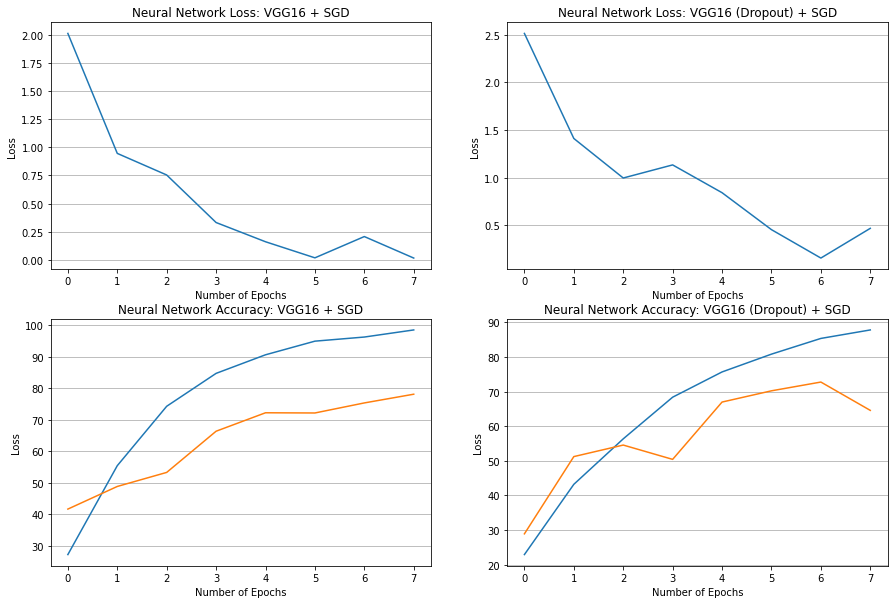

In [13]:
vgg_fig, vgg_axs = plt.subplots(2, 2, figsize=(15, 10))
vgg_axs[0,0].plot(list(map(lambda x: x[-1], vgg_loss_history)))
vgg_axs[0,0].grid(axis='y')
vgg_axs[0,0].set_title("Neural Network Loss: VGG16 + SGD")    
vgg_axs[0,0].set_xlabel("Number of Epochs")
vgg_axs[0,0].set_ylabel("Loss")
# ax1.show()

vgg_axs[0,1].plot(list(map(lambda x: x[-1], vgg_drp_loss_history)))
vgg_axs[0,1].grid(axis='y')
vgg_axs[0,1].set_title("Neural Network Loss: VGG16 (Dropout) + SGD")    
vgg_axs[0,1].set_xlabel("Number of Epochs")
vgg_axs[0,1].set_ylabel("Loss")
# ax2.show()

vgg_axs[1,0].plot(list(map(lambda x: float(x), vgg_train_acc_history)), label="Train")
vgg_axs[1,0].plot(list(map(lambda x: float(x), vgg_test_acc_history)), label="Test")
vgg_axs[1,0].grid(axis='y')
vgg_axs[1,0].set_title("Neural Network Accuracy: VGG16 + SGD")    
vgg_axs[1,0].set_xlabel("Number of Epochs")
vgg_axs[1,0].set_ylabel("Loss")

vgg_axs[1,1].plot(list(map(lambda x: float(x), vgg_drp_train_acc_history)), label="Train")
vgg_axs[1,1].plot(list(map(lambda x: float(x), vgg_drp_test_acc_history)), label="Test")
vgg_axs[1,1].grid(axis='y')
vgg_axs[1,1].set_title("Neural Network Accuracy: VGG16 (Dropout) + SGD")    
vgg_axs[1,1].set_xlabel("Number of Epochs")
vgg_axs[1,1].set_ylabel("Loss")

vgg_accuracy = evaluate(vgg, fish_test_dataset)
print(f"VGG16 Final accuracy = {vgg_accuracy / len(fish_test_set)*100:.2f}%")
vgg_drp_accuracy = evaluate(vgg_drp, fish_test_dataset)
print(f"VGG16 (Dropout) Final accuracy = {vgg_drp_accuracy / len(fish_test_set)*100:.2f}%")

# Lenet Training

In [9]:
lenet_learning_rate = 0.02
lenet_nepochs = 20
lenet_batch_size = 16

lenet_fish_train_dataset = DataLoader(fish_train_set, batch_size=lenet_batch_size)
lenet_fish_test_dataset = DataLoader(fish_test_set, batch_size=lenet_batch_size)

loss_function = nn.CrossEntropyLoss()

In [59]:
lenet_1 = LeNet(num_classes=30).to(device)
lenet_optimizer_adam = optim.Adam(lenet_1.parameters(), lr=lenet_learning_rate)

print("Training Lenet + Adam optimizer...")
# lenet_1 = lenet_1.to(device)
lenet_1.train()
lenet_loss_history_1 = []
lenet_train_acc_history_1 = []
lenet_test_acc_history_1 = []
for epoch in tqdm(range(lenet_nepochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
    loss_history, accuracy = (train_epoch(model=lenet_1, 
                                          train_data=lenet_fish_train_dataset, 
                                          LossFunction=loss_function, 
                                          optimizer=lenet_optimizer_adam))
    lenet_loss_history_1.append(loss_history)
    lenet_train_acc_history_1.append(accuracy)
    lenet_test_acc_history_1.append((evaluate(lenet_1, lenet_fish_test_dataset) / len(fish_test_set)) * 100)

    print(f"Epoch {epoch}:\ntrain loss: {lenet_loss_history_1[-1][-1]}"
          f"\ntrain acc:  {float(lenet_train_acc_history_1[-1])} test acc: {float(lenet_test_acc_history_1[-1])}")

Training Lenet + Adam optimizer...


Epoch:   5%|███▋                                                                     | 1/20 [00:28<08:54, 28.13s/epoch]

Epoch 0:
train loss: 2.544456958770752
train acc:  12.442211151123047 test acc: 18.82253646850586


Epoch:  10%|███████▎                                                                 | 2/20 [00:56<08:23, 27.99s/epoch]

Epoch 1:
train loss: 2.0306358337402344
train acc:  27.035175323486328 test acc: 32.87613296508789


Epoch:  15%|██████████▉                                                              | 3/20 [01:23<07:51, 27.75s/epoch]

Epoch 2:
train loss: 1.5928200483322144
train acc:  35.29648208618164 test acc: 39.945133209228516


Epoch:  20%|██████████████▌                                                          | 4/20 [01:50<07:22, 27.63s/epoch]

Epoch 3:
train loss: 1.4513912200927734
train acc:  42.5728645324707 test acc: 44.165435791015625


Epoch:  25%|██████████████████▎                                                      | 5/20 [02:18<06:53, 27.54s/epoch]

Epoch 4:
train loss: 1.7015297412872314
train acc:  47.27638244628906 test acc: 44.3553466796875


Epoch:  30%|█████████████████████▉                                                   | 6/20 [02:45<06:25, 27.51s/epoch]

Epoch 5:
train loss: 1.2641470432281494
train acc:  50.95477294921875 test acc: 49.03988265991211


Epoch:  35%|█████████████████████████▌                                               | 7/20 [03:13<05:57, 27.50s/epoch]

Epoch 6:
train loss: 1.4061520099639893
train acc:  53.32663345336914 test acc: 49.37750244140625


Epoch:  40%|█████████████████████████████▏                                           | 8/20 [03:40<05:30, 27.58s/epoch]

Epoch 7:
train loss: 1.3240585327148438
train acc:  56.38190841674805 test acc: 49.27199935913086


Epoch:  45%|████████████████████████████████▊                                        | 9/20 [04:08<05:03, 27.55s/epoch]

Epoch 8:
train loss: 1.000498652458191
train acc:  57.94974899291992 test acc: 50.432579040527344


Epoch:  50%|████████████████████████████████████                                    | 10/20 [04:35<04:35, 27.51s/epoch]

Epoch 9:
train loss: 1.1836451292037964
train acc:  60.160804748535156 test acc: 50.32707595825195


Epoch:  55%|███████████████████████████████████████▌                                | 11/20 [05:03<04:07, 27.49s/epoch]

Epoch 10:
train loss: 0.89803546667099
train acc:  63.055274963378906 test acc: 52.14180374145508


Epoch:  60%|███████████████████████████████████████████▏                            | 12/20 [05:30<03:39, 27.49s/epoch]

Epoch 11:
train loss: 0.7816775441169739
train acc:  63.55778884887695 test acc: 53.00696563720703


Epoch:  65%|██████████████████████████████████████████████▊                         | 13/20 [05:58<03:12, 27.51s/epoch]

Epoch 12:
train loss: 0.63227379322052
train acc:  65.12562561035156 test acc: 51.550960540771484


Epoch:  70%|██████████████████████████████████████████████████▍                     | 14/20 [06:25<02:45, 27.50s/epoch]

Epoch 13:
train loss: 0.7228593826293945
train acc:  66.07035064697266 test acc: 52.247310638427734


Epoch:  75%|██████████████████████████████████████████████████████                  | 15/20 [06:53<02:17, 27.58s/epoch]

Epoch 14:
train loss: 0.8648644685745239
train acc:  67.47738647460938 test acc: 54.27305221557617


Epoch:  80%|█████████████████████████████████████████████████████████▌              | 16/20 [07:21<01:50, 27.69s/epoch]

Epoch 15:
train loss: 0.9639006853103638
train acc:  68.44220733642578 test acc: 54.08313751220703


Epoch:  85%|█████████████████████████████████████████████████████████████▏          | 17/20 [07:48<01:22, 27.60s/epoch]

Epoch 16:
train loss: 0.8258293271064758
train acc:  69.12562561035156 test acc: 55.05380630493164


Epoch:  90%|████████████████████████████████████████████████████████████████▊       | 18/20 [08:16<00:54, 27.48s/epoch]

Epoch 17:
train loss: 0.5913193821907043
train acc:  71.03517150878906 test acc: 53.9354248046875


Epoch:  95%|████████████████████████████████████████████████████████████████████▍   | 19/20 [08:43<00:27, 27.38s/epoch]

Epoch 18:
train loss: 0.7652680277824402
train acc:  71.03517150878906 test acc: 55.9400749206543


Epoch: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [09:10<00:00, 27.54s/epoch]

Epoch 19:
train loss: 0.48530450463294983
train acc:  72.30150604248047 test acc: 54.673980712890625


In [65]:
lenet_2 = LeNet(num_classes=30).to(device)
lenet_optimizer_sgd = optim.SGD(lenet_2.parameters(), lr=lenet_learning_rate)

print("Training Lenet + SGD optimizer...")
# lenet_2 = lenet_2.to(device)
lenet_2.train()
lenet_loss_history_2 = []
lenet_train_acc_history_2 = []
lenet_test_acc_history_2 = []
for epoch in tqdm(range(lenet_nepochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
    loss_history, accuracy = (train_epoch(model=lenet_2, 
                                          train_data=lenet_fish_train_dataset, 
                                          LossFunction=loss_function, 
                                          optimizer=lenet_optimizer_sgd))
    lenet_loss_history_2.append(loss_history)
    lenet_train_acc_history_2.append(accuracy)
    lenet_test_acc_history_2.append((evaluate(lenet_2, lenet_fish_test_dataset) / len(fish_test_set)) * 100)

    print(f"Epoch {epoch}:\ntrain loss: {lenet_loss_history_2[-1][-1]}"
          f"\ntrain acc:  {float(lenet_train_acc_history_2[-1])} test acc: {float(lenet_test_acc_history_2[-1])}")

Training Lenet + SGD optimizer...


Epoch:   5%|███▋                                                                     | 1/20 [00:27<08:50, 27.91s/epoch]

Epoch 0:
train loss: 3.239281177520752
train acc:  4.341708660125732 test acc: 7.069002151489258


Epoch:  10%|███████▎                                                                 | 2/20 [00:55<08:22, 27.92s/epoch]

Epoch 1:
train loss: 2.703260660171509
train acc:  12.16080379486084 test acc: 17.197721481323242


Epoch:  15%|██████████▉                                                              | 3/20 [01:23<07:50, 27.66s/epoch]

Epoch 2:
train loss: 2.3288893699645996
train acc:  19.135677337646484 test acc: 23.57037353515625


Epoch:  20%|██████████████▌                                                          | 4/20 [01:50<07:22, 27.68s/epoch]

Epoch 3:
train loss: 2.141772508621216
train acc:  26.33165740966797 test acc: 28.381515502929688


Epoch:  25%|██████████████████▎                                                      | 5/20 [02:18<06:52, 27.53s/epoch]

Epoch 4:
train loss: 2.2077724933624268
train acc:  31.63819122314453 test acc: 32.34859848022461


Epoch:  30%|█████████████████████▉                                                   | 6/20 [02:45<06:24, 27.46s/epoch]

Epoch 5:
train loss: 2.052351951599121
train acc:  35.97990036010742 test acc: 36.14686584472656


Epoch:  35%|█████████████████████████▌                                               | 7/20 [03:12<05:56, 27.40s/epoch]

Epoch 6:
train loss: 1.8221180438995361
train acc:  39.43718719482422 test acc: 38.32032012939453


Epoch:  40%|█████████████████████████████▏                                           | 8/20 [03:40<05:28, 27.37s/epoch]

Epoch 7:
train loss: 1.722740888595581
train acc:  42.89447021484375 test acc: 42.498416900634766


Epoch:  45%|████████████████████████████████▊                                        | 9/20 [04:08<05:03, 27.59s/epoch]

Epoch 8:
train loss: 1.533639669418335
train acc:  45.82914352416992 test acc: 44.31314468383789


Epoch:  50%|████████████████████████████████████                                    | 10/20 [04:35<04:36, 27.62s/epoch]

Epoch 9:
train loss: 1.3409837484359741
train acc:  48.4824104309082 test acc: 45.748050689697266


Epoch:  55%|███████████████████████████████████████▌                                | 11/20 [05:03<04:08, 27.64s/epoch]

Epoch 10:
train loss: 1.139137625694275
train acc:  51.23617935180664 test acc: 47.288455963134766


Epoch:  60%|███████████████████████████████████████████▏                            | 12/20 [05:30<03:40, 27.57s/epoch]

Epoch 11:
train loss: 1.0990087985992432
train acc:  53.52763748168945 test acc: 47.562774658203125


Epoch:  65%|██████████████████████████████████████████████▊                         | 13/20 [05:58<03:13, 27.61s/epoch]

Epoch 12:
train loss: 1.015456199645996
train acc:  56.70351791381836 test acc: 50.896812438964844


Epoch:  70%|██████████████████████████████████████████████████▍                     | 14/20 [06:26<02:46, 27.81s/epoch]

Epoch 13:
train loss: 0.8751989603042603
train acc:  59.778892517089844 test acc: 51.44545364379883


Epoch:  75%|██████████████████████████████████████████████████████                  | 15/20 [06:54<02:19, 27.88s/epoch]

Epoch 14:
train loss: 0.799528181552887
train acc:  61.809043884277344 test acc: 51.95188522338867


Epoch:  80%|█████████████████████████████████████████████████████████▌              | 16/20 [07:22<01:51, 27.91s/epoch]

Epoch 15:
train loss: 0.5891714096069336
train acc:  63.51758575439453 test acc: 52.120697021484375


Epoch:  85%|█████████████████████████████████████████████████████████████▏          | 17/20 [07:50<01:23, 27.89s/epoch]

Epoch 16:
train loss: 0.5735527873039246
train acc:  65.16582489013672 test acc: 54.441864013671875


Epoch:  90%|████████████████████████████████████████████████████████████████▊       | 18/20 [08:18<00:55, 27.91s/epoch]

Epoch 17:
train loss: 0.594608724117279
train acc:  67.21607971191406 test acc: 54.10424041748047


Epoch:  95%|████████████████████████████████████████████████████████████████████▍   | 19/20 [08:46<00:27, 27.93s/epoch]

Epoch 18:
train loss: 0.414633572101593
train acc:  68.8241195678711 test acc: 55.792362213134766


Epoch: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [09:14<00:00, 27.73s/epoch]

Epoch 19:
train loss: 0.5177825689315796
train acc:  70.29145812988281 test acc: 53.70331573486328


Lenet + Adam Final accuracy = 54.74%
Lenet + SGD Final accuracy = 53.58%


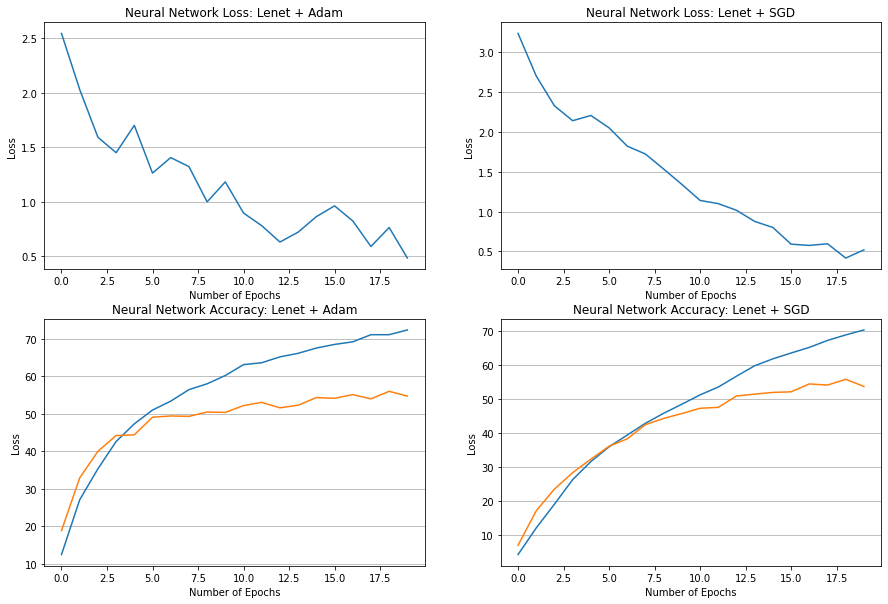

In [66]:
lenet_fig, lenet_axs = plt.subplots(2, 2, figsize=(15, 10))
lenet_axs[0,0].plot(list(map(lambda x: x[-1], lenet_loss_history_1)))
lenet_axs[0,0].grid(axis='y')
lenet_axs[0,0].set_title("Neural Network Loss: Lenet + Adam")    
lenet_axs[0,0].set_xlabel("Number of Epochs")
lenet_axs[0,0].set_ylabel("Loss")
# ax1.show()

lenet_axs[0,1].plot(list(map(lambda x: x[-1], lenet_loss_history_2)))
lenet_axs[0,1].grid(axis='y')
lenet_axs[0,1].set_title("Neural Network Loss: Lenet + SGD")    
lenet_axs[0,1].set_xlabel("Number of Epochs")
lenet_axs[0,1].set_ylabel("Loss")
# ax2.show()

lenet_axs[1,0].plot(list(map(lambda x: float(x), lenet_train_acc_history_1)), label="Train")
lenet_axs[1,0].plot(list(map(lambda x: float(x), lenet_test_acc_history_1)), label="Test")
lenet_axs[1,0].grid(axis='y')
lenet_axs[1,0].set_title("Neural Network Accuracy: Lenet + Adam")    
lenet_axs[1,0].set_xlabel("Number of Epochs")
lenet_axs[1,0].set_ylabel("Loss")

lenet_axs[1,1].plot(list(map(lambda x: float(x), lenet_train_acc_history_2)), label="Train")
lenet_axs[1,1].plot(list(map(lambda x: float(x), lenet_test_acc_history_2)), label="Test")
lenet_axs[1,1].grid(axis='y')
lenet_axs[1,1].set_title("Neural Network Accuracy: Lenet + SGD")    
lenet_axs[1,1].set_xlabel("Number of Epochs")
lenet_axs[1,1].set_ylabel("Loss")

lenet_accuracy_1 = evaluate(lenet_1, fish_test_dataset)
print(f"Lenet + Adam Final accuracy = {lenet_accuracy_1 / len(fish_test_set)*100:.2f}%")
lenet_accuracy_2 = evaluate(lenet_2, fish_test_dataset)
print(f"Lenet + SGD Final accuracy = {lenet_accuracy_2 / len(fish_test_set)*100:.2f}%")

<br><span style="color:black;font-size:35px">**AlexNet**</span>

In [10]:
alex_learning_rate = 1e-2
alex_batch_size = 32
alex_momentum = 0.9
alex_nepochs = 8
alex_pt_nepochs = 5

alex_transform = T.Compose([T.Resize(size=(227,227)),
#                             T.CenterCrop(224),
                            T.RandomHorizontalFlip(),
                            T.ToTensor(), 
                            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                           ])

alex_fish_train_set = FishDataset(FILEPATH, 
                                  train=True, 
                                  shuffle=True, 
                                  transform=alex_transform)
alex_fish_test_set = FishDataset(FILEPATH, 
                                 train=False, 
                                 shuffle=False, 
                                 transform=alex_transform)

alex_train_dataset = DataLoader(alex_fish_train_set, batch_size=alex_batch_size)
alex_test_dataset = DataLoader(alex_fish_test_set, batch_size=alex_batch_size)

alex_loss_function = nn.CrossEntropyLoss()

In [26]:
alex = AlexNet(nout=30).to(device)
# print(device)
# alex = torch.hub.load("pytorch/vision:v0.6.0", "alexnet", pretrained=False)
# alex.classifier[4] = nn.Linear(4096, 1024)
# alex.classifier[6] = nn.Linear(1024, 30)
# alex = alex.to(device)
# alex.fc = nn.Sequential(nn.Linear(2048, num_classes), nn.Sigmoid())
print(alex)

alex_optimizer_sgd = optim.SGD(alex.parameters(), lr=alex_learning_rate)

alex.train()
alex_loss_history = []
alex_train_acc_history = []
alex_test_acc_history = []
for epoch in tqdm(range(alex_nepochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
    loss_history, accuracy = (train_epoch(model=alex, 
                                          train_data=alex_train_dataset, 
                                          LossFunction=alex_loss_function, 
                                          optimizer=alex_optimizer_sgd))
    alex_loss_history.append(loss_history)
    alex_train_acc_history.append(accuracy)
    alex_test_acc_history.append((evaluate(alex, alex_test_dataset) / len(alex_fish_test_set)) * 100)

    print(f"Epoch {epoch}:\ntrain loss: {alex_loss_history[-1][-1]}"
          f"\ntrain acc:  {float(alex_train_acc_history[-1])} test acc: {float(alex_test_acc_history[-1])}")

AlexNet(
  (conv_1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (conv_2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv_3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear_1): Linear(in_features=9216, out_features=4096, bias=True)
  (linear_2): Linear(in_features=4096, out_features=4096, bias=True)
  (linear_3): Linear(in_features=4096, out_features=30, bias=True)
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.5, inplace=False)
)


Epoch:  10%|███████▎                                                                 | 1/10 [00:45<06:45, 45.03s/epoch]

Epoch 0:
train loss: 2.5816760063171387
train acc:  13.889447212219238 test acc: 18.44270896911621


Epoch:  20%|██████████████▌                                                          | 2/10 [01:30<06:00, 45.06s/epoch]

Epoch 1:
train loss: 2.0491156578063965
train acc:  30.91457176208496 test acc: 25.680524826049805


Epoch:  30%|█████████████████████▉                                                   | 3/10 [02:16<05:20, 45.77s/epoch]

Epoch 2:
train loss: 1.3653696775436401
train acc:  41.40703582763672 test acc: 34.58535385131836


Epoch:  40%|█████████████████████████████▏                                           | 4/10 [03:02<04:33, 45.61s/epoch]

Epoch 3:
train loss: 1.072389841079712
train acc:  50.31155776977539 test acc: 47.66828536987305


Epoch:  50%|████████████████████████████████████▌                                    | 5/10 [03:46<03:46, 45.31s/epoch]

Epoch 4:
train loss: 1.097881555557251
train acc:  57.94974899291992 test acc: 45.55813217163086


Epoch:  60%|███████████████████████████████████████████▊                             | 6/10 [04:33<03:03, 45.77s/epoch]

Epoch 5:
train loss: 0.6827458143234253
train acc:  63.195980072021484 test acc: 55.43363571166992


Epoch:  70%|███████████████████████████████████████████████████                      | 7/10 [05:18<02:16, 45.42s/epoch]

Epoch 6:
train loss: 0.47988706827163696
train acc:  67.91959381103516 test acc: 64.48617553710938


Epoch:  80%|██████████████████████████████████████████████████████████▍              | 8/10 [06:03<01:31, 45.51s/epoch]

Epoch 7:
train loss: 0.22099967300891876
train acc:  72.02010345458984 test acc: 69.80375671386719


Epoch:  90%|█████████████████████████████████████████████████████████████████▋       | 9/10 [06:50<00:45, 45.73s/epoch]

Epoch 8:
train loss: 0.5329698920249939
train acc:  75.51758575439453 test acc: 54.84279251098633


Epoch: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [07:36<00:00, 45.61s/epoch]

Epoch 9:
train loss: 0.2512756288051605
train acc:  78.55276489257812 test acc: 72.3570327758789


In [29]:
# alex = AlexNet(nout=30).to(device)
print(device)
alex_pt = torch.hub.load("pytorch/vision:v0.6.0", "alexnet", pretrained=True)
alex_pt.classifier[4] = nn.Linear(4096, 1024)
alex_pt.classifier[6] = nn.Linear(1024, 30)
alex_pt = alex_pt.to(device)
# alex.fc = nn.Sequential(nn.Linear(2048, num_classes), nn.Sigmoid())
print(alex_pt)

alex_pt_optimizer_sgd = optim.SGD(alex_pt.parameters(), lr=alex_learning_rate)

alex_pt.train()
alex_pt_loss_history = []
alex_pt_train_acc_history = []
alex_pt_test_acc_history = []
for epoch in tqdm(range(alex_pt_nepochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
    loss_history, accuracy = (train_epoch(model=alex_pt, 
                                          train_data=alex_train_dataset, 
                                          LossFunction=alex_loss_function, 
                                          optimizer=alex_pt_optimizer_sgd))
    alex_pt_loss_history.append(loss_history)
    alex_pt_train_acc_history.append(accuracy)
    alex_pt_test_acc_history.append((evaluate(alex_pt, alex_test_dataset) / len(alex_fish_test_set)) * 100)

    print(f"Epoch {epoch}:\ntrain loss: {alex_pt_loss_history[-1][-1]}"
          f"\ntrain acc:  {float(alex_pt_train_acc_history[-1])} test acc: {float(alex_pt_test_acc_history[-1])}")

cuda


Using cache found in C:\Users\Evant/.cache\torch\hub\pytorch_vision_v0.6.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Epoch:  20%|██████████████▊                                                           | 1/5 [00:44<02:57, 44.33s/epoch]

Epoch 0:
train loss: 0.321952760219574
train acc:  66.07035064697266 test acc: 87.78223419189453


Epoch:  40%|█████████████████████████████▌                                            | 2/5 [01:27<02:11, 43.89s/epoch]

Epoch 1:
train loss: 0.09610537439584732
train acc:  88.14070129394531 test acc: 89.17493438720703


Epoch:  60%|████████████████████████████████████████████▍                             | 3/5 [02:11<01:27, 43.66s/epoch]

Epoch 2:
train loss: 0.2928181290626526
train acc:  91.91959381103516 test acc: 78.49757385253906


Epoch:  80%|███████████████████████████████████████████████████████████▏              | 4/5 [02:56<00:44, 44.13s/epoch]

Epoch 3:
train loss: 0.0011505857110023499
train acc:  94.43215942382812 test acc: 92.48786926269531


Epoch: 100%|██████████████████████████████████████████████████████████████████████████| 5/5 [03:40<00:00, 44.19s/epoch]

Epoch 4:
train loss: 0.018059931695461273
train acc:  95.77889251708984 test acc: 93.2264175415039


AlexNet Final accuracy = 72.63%
AlexNet (Pretrained) Final accuracy = 93.29%


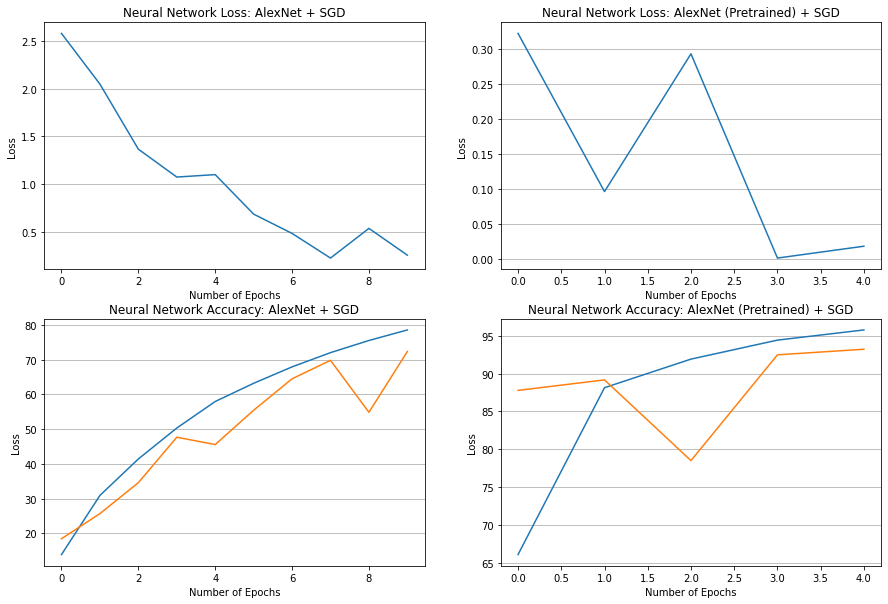

In [30]:
alex_fig, alex_axs = plt.subplots(2, 2, figsize=(15, 10))
alex_axs[0,0].plot(list(map(lambda x: x[-1], alex_loss_history)))
alex_axs[0,0].grid(axis='y')
alex_axs[0,0].set_title("Neural Network Loss: AlexNet + SGD")    
alex_axs[0,0].set_xlabel("Number of Epochs")
alex_axs[0,0].set_ylabel("Loss")

alex_axs[0,1].plot(list(map(lambda x: x[-1], alex_pt_loss_history)))
alex_axs[0,1].grid(axis='y')
alex_axs[0,1].set_title("Neural Network Loss: AlexNet (Pretrained) + SGD")    
alex_axs[0,1].set_xlabel("Number of Epochs")
alex_axs[0,1].set_ylabel("Loss")

alex_axs[1,0].plot(list(map(lambda x: float(x), alex_train_acc_history)), label="Train")
alex_axs[1,0].plot(list(map(lambda x: float(x), alex_test_acc_history)), label="Test")
alex_axs[1,0].grid(axis='y')
alex_axs[1,0].set_title("Neural Network Accuracy: AlexNet + SGD")    
alex_axs[1,0].set_xlabel("Number of Epochs")
alex_axs[1,0].set_ylabel("Loss")

alex_axs[1,1].plot(list(map(lambda x: float(x), alex_pt_train_acc_history)), label="Train")
alex_axs[1,1].plot(list(map(lambda x: float(x), alex_pt_test_acc_history)), label="Test")
alex_axs[1,1].grid(axis='y')
alex_axs[1,1].set_title("Neural Network Accuracy: AlexNet (Pretrained) + SGD")    
alex_axs[1,1].set_xlabel("Number of Epochs")
alex_axs[1,1].set_ylabel("Loss")

alex_accuracy = evaluate(alex, alex_test_dataset)
print(f"AlexNet Final accuracy = {alex_accuracy / len(alex_fish_test_set)*100:.2f}%")
alex_pt_accuracy = evaluate(alex_pt, alex_test_dataset)
print(f"AlexNet (Pretrained) Final accuracy = {alex_pt_accuracy / len(alex_fish_test_set)*100:.2f}%")

<br><span style="color:black;font-size:35px">**ResNet**</span>

In [8]:
resnet_learning_rate = 1e-2
resnet_batch_size = 32
resnet_momentum = 0.9
resnet_nepochs = 10
resnet_pt_nepochs = 5

resnet_transform = T.Compose([T.Resize(size=(224,224)),
#                             T.CenterCrop(224),
                            T.RandomHorizontalFlip(),
                            T.ToTensor(), 
                            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                           ])

resnet_fish_train_set = FishDataset(FILEPATH, 
                                  train=True, 
                                  shuffle=True, 
                                  transform=resnet_transform)
resnet_fish_test_set = FishDataset(FILEPATH, 
                                 train=False, 
                                 shuffle=False, 
                                 transform=resnet_transform)

resnet_train_dataset = DataLoader(resnet_fish_train_set, batch_size=resnet_batch_size)
resnet_test_dataset = DataLoader(resnet_fish_test_set, batch_size=resnet_batch_size)

resnet_loss_function = nn.CrossEntropyLoss()

In [9]:
resnet = torch.hub.load("pytorch/vision:v0.10.0", "resnet50", pretrained=True)
resnet.fc = nn.Sequential(nn.Linear(2048, 30), nn.Sigmoid())
resnet = resnet.to(device)
print(resnet)

resnet_optimizer_sgd = optim.SGD(resnet.parameters(), lr=resnet_learning_rate)

resnet.train()
resnet_loss_history = []
resnet_train_acc_history = []
resnet_test_acc_history = []
for epoch in tqdm(range(resnet_nepochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
    loss_history, accuracy = (train_epoch(model=resnet, 
                                          train_data=resnet_train_dataset, 
                                          LossFunction=resnet_loss_function, 
                                          optimizer=resnet_optimizer_sgd))
    resnet_loss_history.append(loss_history)
    resnet_train_acc_history.append(accuracy)
    resnet_test_acc_history.append((evaluate(resnet, resnet_test_dataset) / len(resnet_fish_test_set)) * 100)

    print(f"Epoch {epoch}:\ntrain loss: {resnet_loss_history[-1][-1]}"
          f"\ntrain acc:  {float(resnet_train_acc_history[-1])} test acc: {float(resnet_test_acc_history[-1])}")

Using cache found in C:\Users\Evant/.cache\torch\hub\pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Epoch:   0%|                                                                                 | 0/10 [00:00<?, ?epoch/s]C:\Users\Evant\anaconda3\envs\other\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch:  10%|███████▎                                                                 | 1/10 [01:20<12:08, 80.91s/epoch]

Epoch 0:
train loss: 3.1483044624328613
train acc:  37.18592834472656 test acc: 70.90103149414062


Epoch:  20%|██████████████▌                                                          | 2/10 [02:39<10:38, 79.81s/epoch]

Epoch 1:
train loss: 2.9153826236724854
train acc:  81.98995208740234 test acc: 85.3133544921875


Epoch:  30%|█████████████████████▉                                                   | 3/10 [03:56<09:08, 78.39s/epoch]

Epoch 2:
train loss: 2.7723588943481445
train acc:  89.34673309326172 test acc: 89.32263946533203


Epoch:  40%|█████████████████████████████▏                                           | 4/10 [05:09<07:38, 76.36s/epoch]

Epoch 3:
train loss: 2.695906400680542
train acc:  91.71858978271484 test acc: 91.30618286132812


Epoch:  50%|████████████████████████████████████▌                                    | 5/10 [06:23<06:16, 75.28s/epoch]

Epoch 4:
train loss: 2.6464507579803467
train acc:  93.26632690429688 test acc: 92.40345764160156


Epoch:  60%|███████████████████████████████████████████▊                             | 6/10 [07:36<04:58, 74.67s/epoch]

Epoch 5:
train loss: 2.613037586212158
train acc:  94.31155395507812 test acc: 92.80438995361328


Epoch:  70%|███████████████████████████████████████████████████                      | 7/10 [08:49<03:42, 74.17s/epoch]

Epoch 6:
train loss: 2.5917677879333496
train acc:  95.09547424316406 test acc: 93.12091064453125


Epoch:  80%|██████████████████████████████████████████████████████████▍              | 8/10 [10:03<02:27, 73.92s/epoch]

Epoch 7:
train loss: 2.5714690685272217
train acc:  95.61808776855469 test acc: 93.58514404296875


Epoch:  90%|█████████████████████████████████████████████████████████████████▋       | 9/10 [11:18<01:14, 74.21s/epoch]

Epoch 8:
train loss: 2.556766986846924
train acc:  95.87939453125 test acc: 93.92276763916016


Epoch: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [12:32<00:00, 75.25s/epoch]

Epoch 9:
train loss: 2.5470008850097656
train acc:  96.36180877685547 test acc: 94.36589813232422


ResNet Final accuracy = 94.41%


Text(0, 0.5, 'Accuracy')

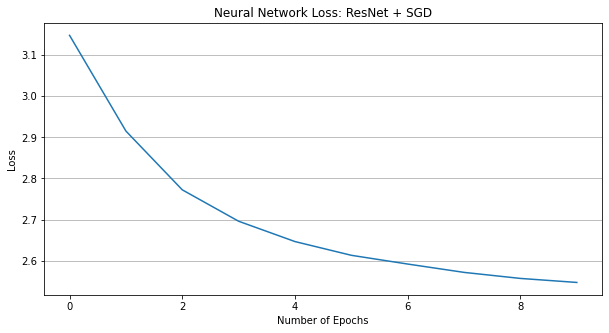

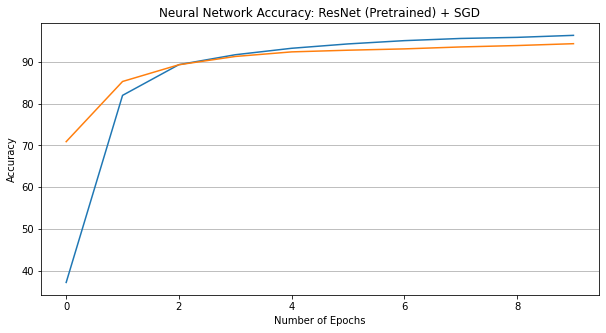

In [16]:
resnet_accuracy = evaluate(resnet, resnet_test_dataset)
print(f"ResNet Final accuracy = {resnet_accuracy / len(resnet_fish_test_set)*100:.2f}%")

resnet_fig1, resnet_axs1 = plt.subplots(1, 1, figsize=(10, 5))
resnet_axs1.plot(list(map(lambda x: x[-1], resnet_loss_history)))
resnet_axs1.grid(axis='y')
resnet_axs1.set_title("Neural Network Loss: ResNet + SGD")    
resnet_axs1.set_xlabel("Number of Epochs")
resnet_axs1.set_ylabel("Loss")
resnet_fig2, resnet_axs2 = plt.subplots(1, 1, figsize=(10, 5))
resnet_axs2.plot(list(map(lambda x: float(x), resnet_train_acc_history)), label="Train")
resnet_axs2.plot(list(map(lambda x: float(x), resnet_test_acc_history)), label="Test")
resnet_axs2.grid(axis='y')
resnet_axs2.set_title("Neural Network Accuracy: ResNet (Pretrained) + SGD")    
resnet_axs2.set_xlabel("Number of Epochs")
resnet_axs2.set_ylabel("Accuracy")